# Pokemon GAN

Idea: Make a condition GAN that takes in types and produces pokemon.

There are ~800 pokemon, which is a small number of images to train over. In order to inflate this number, we will use a random transform on each image.

In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from PIL import Image
import re
import json

import numpy
from numpy import median
from numpy.random import choice
from torchvision.transforms import Compose, ToTensor, Normalize, RandomAffine, RandomHorizontalFlip
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision.utils import make_grid, save_image
from torch.nn import BCEWithLogitsLoss

print('Current working directory: ', os.getcwd())
try:
    os.mkdir(os.getcwd()+'/samples')
    print('Making samples directory')
except FileExistsError:
    print('Using samples directory')
    pass

#Pick batch size
batch_size = 16

#set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Current working directory:  D:\Code\pytorch_VAEs
Using samples directory


In [2]:
# def label_encoding(idx_list, classes=18):
#     labels = numpy.zeros((1, classes))
#     numpy.add.at(labels, (0, idx_list), 1)
#     return labels

# print(label_encoding([0, 3]))

## Pokedex
We create a simple pokedex from which we will pull images. It takes in an image directory, a pokedex json file and a types json file.

In [3]:
# def scale(images):
#     return (images-.5)*2

# def descale(images):
#     return (images+1)/2
import re
import json
class pokedex:
    def __init__(self, directory, input_transform = None, pokedex_json='pokedex.json', types_json='types.json'):
        ##Create pokedex dictionary in the form {id: type} 
        ##from json file
        self.classes, self.classes_to_idx = self._get_types_and_classes(directory, types_json)
        pdx = self._build_pokedex(directory, pokedex_json)
        
        ##Get images
        data = []
        encodings = []
        #Only load base pokemon. This is a short term solution to variant type pokemon.
        matcher = re.compile('^\d+.png')
        splitter = re.compile('[^ a-zA-Z0-9]')
        for file_name in os.listdir(directory):
            #Split up name
            match = matcher.match(file_name)
            file_split = splitter.split(file_name)
            #Only use files of the form x.png, as these are base pokemon
            if len(file_split) == 2 and match is not None:
                #Get file path
                file_path = directory+file_name
                #Get type info
                poke_id = int(file_split[0])
                
                data.append((file_path, pdx[poke_id]))
                type_info = pdx[poke_id]['type']

                encoded_types = torch.zeros((len(self.classes)))
                for type in type_info:
                    encoded_types[self.classes_to_idx[type]] = 1.
                encodings.append(encoded_types)
                
        self.data = data
        self.encodings = encodings
        self.input_transform = input_transform
        
    def __getitem__(self, idx):
        image_path, _ = self.data[idx]
        
        image = Image.open(image_path).convert('RGB')
        if self.input_transform is not None:
            image = self.input_transform(image)
        encoded_types = self.encodings[idx]
        return (image, encoded_types)
    
    def __len__(self):
        return len(self.data)
    
    @staticmethod
    def _get_types_and_classes(directory, types_json):
        with open(directory+types_json, encoding='utf-8') as file:
            type_data = json.load(file)
        classes = []
        classes_to_idx = {}
        for idx, entry in enumerate(type_data):
            classes.append(entry['english'])
            classes_to_idx[entry['english']] = idx
        return classes, classes_to_idx
    
    @staticmethod
    def _build_pokedex(directory, pokedex_json):
        pdx = {}
        #Load json info
        with open(directory+pokedex_json, encoding='utf-8') as file:
            pdx_data = json.load(file)
        #Pull out id and type
        for entry in pdx_data:
            pdx[entry['id']] = {'name': entry['name']['english'],
                                'type': entry['type']}
        return pdx

# def generate_types(size, n_types=18, p_two_types=.8):
#     conditions = range(n_types)
#     types = choice(conditions, size=(size, 2), replace=True)
#     types = torch.tensor(types, dtype=torch.long)
#     type1 = torch.nn.functional.one_hot(types[:, 0], n_types)
#     type2 = torch.nn.functional.one_hot(types[:, 1], n_types)
#     return (type1+(torch.rand((size, 1)) < p_two_types)*type2).to(dtype=torch.float)

In [4]:
# print(generate_types(10))

Once we have a pokedex, we create a sampler that chooses a set of pokemon IDs, and returns images and type information for those IDs.

In [5]:
def pokemon_sampler(batch_size, device='cpu'):
    '''
    Create a random batch sampler. This function creates an (infinite) iterator, 
    which can be used to get new samples using next. i.e.
    
    sampler = make_sampler(64, 'cuda')
    sample = next(sampler)
    
    :param batch_size: (int) Number of examples to return
    :param device: (str) Device to move examples to.
    :return: iterator
    '''
    transforms = Compose([
        RandomAffine(5, (.2, .2)),
        RandomHorizontalFlip(),
        ToTensor(),
        Normalize([.5], [.5])
    ])
    pkdx = pokedex('./data/pokemons/', transforms)
    
    while True:
        batch_idx = choice(range(len(pkdx)), batch_size)
        image_tensor = torch.cat([pkdx[idx][0].unsqueeze(0) for idx in batch_idx], 0).to(device)
        label_tensor = torch.cat([pkdx[idx][1].unsqueeze(0) for idx in batch_idx], 0).to(device)
        yield image_tensor, label_tensor

## Noise generator

Now that we have a pokemon image generator, we 

In [6]:
def create_types():
    single_types = []
    double_types = []
    for idx1 in range(18):
        single_type = numpy.zeros(18, dtype=numpy.float32)
        single_type[idx1] = 1
        single_types.append(single_type)
        for idx2 in range(idx1+1, 18):
            double_type = numpy.zeros(18, dtype=numpy.float32)
            double_type[idx1] = 1
            double_type[idx2] = 1
            double_types.append(double_type)

    return single_types, double_types

def type_generator(batch_size):
    single_types, double_types = create_types()
    types = single_types+double_types
    while True:
        idxs = choice(range(len(types)), size=batch_size)
        chosen_types = numpy.concatenate([numpy.expand_dims(types[idx], 0) for idx in idxs], 0)
        yield chosen_types

In [7]:
def noise_generator(batch_size, z_size, device):
    z_noise = torch.zeros((batch_size, z_size), device=device)
    type_gen = type_generator(batch_size)
    while True:
        type_noise = torch.from_numpy(next(type_gen)).to(device)
        z_noise.normal_()
        yield z_noise, type_noise

## Example generator output

In [8]:
#Set up batch loaders
noise_sampler = noise_generator(batch_size, 100, device)
training_sampler = pokemon_sampler(batch_size, device)

Here is an example of the pokemon images fed into the discriminator (before downsampling).

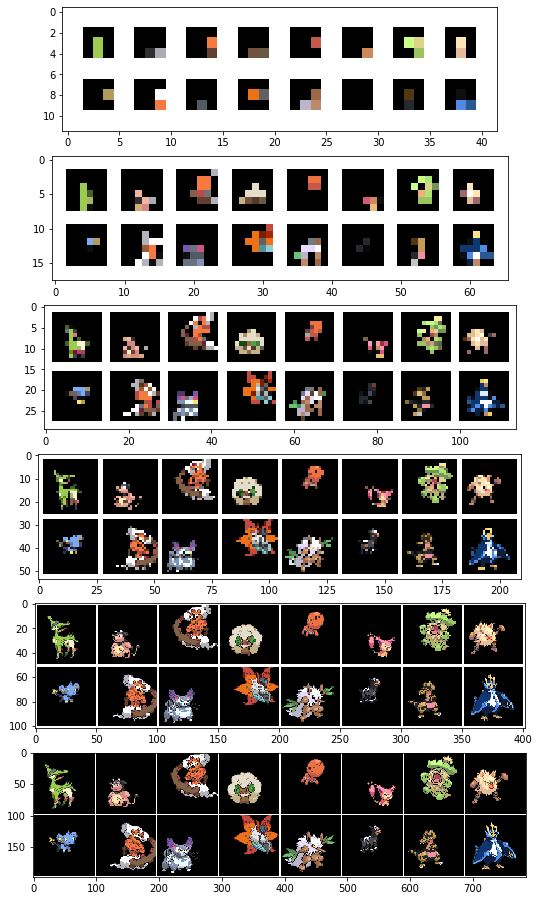

In [9]:
example = next(training_sampler)
images, types = example
fig, ax = plt.subplots(6, 1, figsize=(24,16))
for res in range(6):
    image_size = (3*2**res, 3*2**res)
    image = nn.functional.interpolate(images, image_size)
    image = to_pil_image(make_grid(image, normalize=True, pad_value=1).cpu())
    ax[res].imshow(image)

Below is an example of the noise generator used to create input for the GAN Generator. The first tensor is used to generate image information. The second tensor is used to augment the first tensor with pokemon type information.

In [10]:
example = next(noise_sampler)
print('Random image info: {0}'.format(example[0][0]),
      'Random type: {0}'.format(example[1][0]),
      sep='\n')

Random image info: tensor([ 6.2762e-04, -2.2240e+00, -1.2151e+00, -7.5581e-01, -7.7226e-02,
        -4.8288e-01, -5.2890e-01, -6.9569e-01, -3.0719e-01, -1.1792e+00,
        -9.5734e-01, -6.3185e-03,  6.8255e-01,  8.0052e-01, -2.3932e+00,
         1.6295e+00, -1.3270e-01, -2.0828e-01, -6.8197e-01, -9.6338e-01,
        -1.2551e+00,  3.7616e-01, -4.7942e-01,  1.7299e-01, -4.4295e-01,
         1.7221e+00, -3.4923e-01,  1.9739e+00, -1.5312e+00, -7.3234e-02,
        -2.0553e+00, -8.8712e-01, -1.4306e+00,  7.8061e-02,  2.4087e+00,
         1.5698e+00, -7.8450e-01, -1.8555e-01, -2.1416e-01,  1.8296e-01,
         3.7743e-01,  5.4911e-01, -4.8286e-01,  3.2687e-01, -9.5202e-01,
         4.7896e-01, -1.5751e+00,  9.4993e-02,  3.8215e-01, -8.7874e-01,
         4.2904e-01,  1.4362e+00,  2.8604e+00,  4.4966e-01,  3.1644e+00,
        -6.3050e-01, -2.8479e-01, -1.4678e+00,  1.1873e+00,  9.6475e-01,
        -1.1501e+00, -4.9052e-01,  1.5684e-01, -8.0186e-01,  1.4783e+00,
        -3.0417e-01, -3.3106e-01

## Progressive GAN Trainer
I found my early attempts mostly formed dark clouds with little distinct features. I speculate that this is due to two problems: the high variety of images for a relatively small dataset, and the relatively high resolution of the images (3 x 96 x 96). To deal with the first issue, we use a number of random transformations on the original images before passing it to the discriminator. These transformed images effectively grow the image dataset by offering many similar versions of an image.

To deal with the second issue, we train a progressively growing GAN. Rather than trying to produce full resolution images from the start, we begin by optimizing the network to produce low resolution images (6x6 in this case). As training progresses, the resolution is increased.

In [11]:
def train_GAN(
    generator,
    discriminator,
    gen_optim,
    dis_optim,
    training_sampler,
    noise_sampler,
    epochs=20,
    update_steps=50,
    dis_updates_per_gen=1,
    name='GAN'
):
    '''
    Trains generative adversarial networks. Requires the generator to have a
    generate function (for producing examples), and the discriminator to have
    a loss function (for scoring examples). This allows us to use either a
    standard discriminator or a wGAN critic.
    '''
    generator.train()
    discriminator.train()

    #Fix a generator input for watching image generation change over time
    fixed_z, fixed_types = next(noise_sampler)
    
    #Record history
    gen_scores = []
    dis_scores = []
    
    #Set save directory
    directory = os.getcwd() + '/samples/{0}'.format(name)
    try:
        os.mkdir(directory)
    except FileExistsError:
        pass
    
    for res in range(5):
        i_size = (6*2**res, 6*2**res)
        
        running_g_score = 0.
        running_d_score = 0.
        
        for epoch in range(epochs):
            for _ in range(update_steps):
                for _ in range(dis_updates_per_gen):
                    #Clear gradients
                    dis_optim.zero_grad()
                    #Get original images
                    original_images, original_types = next(training_sampler)
                    original_images = nn.functional.interpolate(original_images, i_size)
                    #Generate images for training discriminator - they do not need gradients
                    with torch.no_grad():
                        z, generated_types = next(noise_sampler)
                        generated_images = generator(z, generated_types, res)

                    #Score images and update discriminator
                    original_scores = discriminator(original_images, original_types, res)
                    generated_scores = discriminator(generated_images, generated_types, res)
                    dis_loss = -torch.mean((original_scores-1).clamp(max=0))-torch.mean((-generated_scores-1).clamp(max=0))
                    dis_loss.backward()
                    dis_optim.step()
                    
                    #Update running scores
                    running_g_score = 0.9*running_g_score + 0.1*float(generated_scores.mean())
                    running_d_score = 0.9*running_d_score + 0.1*float(original_scores.mean())

                #Clear generator gradients
                gen_optim.zero_grad()

                #Generate next fake batch
                z, generated_types = next(noise_sampler)
                generated_images = generator(z, generated_types, res)

                #Aim to decrease loss of scoring them as original
                gen_score = -torch.mean(discriminator(generated_images, generated_types, res))
                gen_score.backward()
                gen_optim.step()

            fixed_generated = generator(fixed_z, fixed_types, res)

            file_name = directory + '/res-{0}-epoch-{1}.png'.format(res, epoch)
            save_image(fixed_generated, file_name, normalize=True, pad_value=1)
            print('\rScale: {0}'.format(res),
                  'Epoch: {0:3}'.format(epoch),
                  'D score: {0:.3f}'.format(running_d_score),
                  'G score: {0:.3f}'.format(running_g_score),
                  sep=' - ')

In [12]:
#Create deep convolution discriminator
#Note: The sigmoid is not included in the sequential, so that we can use
#logits instead. 
class ReshapeLayer(nn.Module):
    '''
    Reshapes the input to be the output using view. Shapes are checked
    on forward pass to verify that they are compatible.

    :param view_shape: The shape to cast the input to. Given a batch
        input of shape (n, _) will be cast to (n, view_shape).
    '''
    def __init__(self, out_shape):
        super(ReshapeLayer, self).__init__()
        self.out_shape = out_shape

    def forward(self, x):
        '''
        Reshapes x to initialized shape.
        :param x: (t.Tensor)
        :return: (t.Tensor)
        '''
        output_shape = (x.shape[0],) + self.out_shape
        assert self.dimension(x.shape) == self.dimension(output_shape), \
            '{0} and {1} are not compatabile'.format(x.shape, output_shape)
        return x.reshape(output_shape)

    @staticmethod
    def dimension(shape):
        #Helper function for checking dimensions
        out = 1
        for s in shape:
            out *= s
        return out
    
    def __repr__(self):
        return 'ReshapeLayer(out_shape={0})'.format(self.out_shape)

class smBN(nn.Module):
    def __init__(self, module, z_size):
        super(smBN, self).__init__()
        if type(module) == nn.Linear:
            self.bn = nn.BatchNorm1d(module.out_features, affine=False)
            out_shape = (1,)
        elif type(module) in [nn.Conv2d, proUpSample]:
            self.bn = nn.BatchNorm2d(module.out_channels, affine=False)
            out_shape = (1, 1, 1)
        else:
            raise ValueError('Module type {0} is not yet implemented'.format(type(module)))
        
        self.module = module
        self.gamma = nn.Sequential(
            nn.Linear(z_size, z_size//2),
            nn.ReLU(),
            nn.Linear(z_size//2, 1),
            ReshapeLayer(out_shape)
        )
        self.beta = nn.Sequential(
            nn.Linear(z_size, z_size//2),
            nn.ReLU(),
            nn.Linear(z_size//2, 1),
            ReshapeLayer(out_shape)
        )
        
    def forward(self, input, z):
        beta, gamma = self.beta(z), self.gamma(z)
        x = self.bn.forward(self.module(input))
        out = gamma*x+beta
        return out
    

In [13]:
class proUpSample(nn.Module):
    def __init__(self, channels, max_steps=1000):
        super(proUpSample, self).__init__()
        
        self.steps = 0
        self.max_steps = max_steps
        self.conv = nn.Conv2d(channels, channels, 3, padding=1, bias=False)
        self.out_channels = channels
        
    def forward(self, input):
        x1 = nn.functional.interpolate(input, scale_factor=2)
        x = self.conv(x1)
        if self.steps < self.max_steps:
            alpha = float(self.steps)/self.max_steps
            x = (1-alpha)*x1+alpha*x
            
            self.steps += 1
        return x

In [14]:
class proDownSample(nn.Module):
    def __init__(self, channels, max_steps=1000):
        super(proDownSample, self).__init__()
        
        self.steps = 0
        self.max_steps = max_steps
        self.conv = nn.utils.spectral_norm(nn.Conv2d(channels, channels, 4, 2, 1, bias=False))
        
    def forward(self, input):
        x = self.conv(input)
        if self.steps < self.max_steps:
            x1 = nn.functional.interpolate(input, scale_factor=.5)
            alpha = float(self.steps)/self.max_steps
            x = (1-alpha)*x1+alpha*x
            
            self.steps += 1
        return x

In [15]:
class Discriminator(nn.Module):
    def __init__(self, condition_size=18, nc=3, hidden_size=64, hidden_channels=64):
        super(Discriminator, self).__init__()
        self.from_rgb = nn.utils.spectral_norm(nn.Conv2d(nc, hidden_channels, 1, bias=False))
        self.down_blocks = nn.ModuleList([
            proDownSample(hidden_channels),
            proDownSample(hidden_channels),
            proDownSample(hidden_channels),
            proDownSample(hidden_channels),
        ])
        
        self.D0 = nn.Sequential(
            #Current shape: hidden_channels x 6 x 6
            nn.Flatten(),
            #Current shape: 36*hidden channels
            nn.utils.spectral_norm(nn.Linear(36*hidden_channels, 8*hidden_size)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(8*hidden_size, 2*hidden_size)),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(nn.Linear(2*hidden_size, hidden_size)),
            nn.LeakyReLU(0.2)
        )
        
        self.D1 = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(hidden_size+condition_size+1, condition_size)),
            nn.LeakyReLU(0.2)
        )
        self.Dfinal = nn.utils.spectral_norm(nn.Linear(condition_size, 1, bias=False))
        
    def forward(self, images, conditions, res=0):
        #Turn into a multi channel image
        x = self.from_rgb(images)
        #Down sample depending on chosen resolution.
        for down_block in self.down_blocks[4-res:]:
            x = nn.functional.leaky_relu(down_block(x), 0.2)
            
        #Run through final layers
        x = self.D0(x)
        #Add the average standard deviation as an extra channel
        #along with conditions
        mean_stdev = images.std(dim=0).mean()
        mean_stdev = mean_stdev.expand((images.shape[0], 1))
        y = torch.cat([x, conditions, mean_stdev], 1)
        y = self.D1(y)
        #Return final assessment
        return self.Dfinal(y) + torch.matmul(y, conditions.T)
        
        
#Create deep convolution generator
class Generator(nn.Module):
    def __init__(self, condition_size=18, nc=3, z_size=100, hidden_channels=64):
        super(Generator, self).__init__()

        self.emb_1 = nn.Linear(condition_size, z_size)
        self.emb_2 = nn.Linear(condition_size, z_size)

        self.from_z = nn.Sequential(
            nn.Linear(z_size, 2*z_size),
            nn.ReLU()
        )
        self.style = nn.ModuleList([
            smBN(nn.Linear(2*z_size, 4*z_size), z_size),
            smBN(nn.Linear(4*z_size, 8*z_size), z_size),
            smBN(nn.Linear(8*z_size, 36*hidden_channels), z_size)
        ])

        self.up_blocks = nn.ModuleList([
            smBN(proUpSample(hidden_channels), z_size),
            smBN(proUpSample(hidden_channels), z_size),
            smBN(proUpSample(hidden_channels), z_size),
            smBN(proUpSample(hidden_channels), z_size)
        ])
        
        self.to_rgb = nn.Conv2d(hidden_channels, nc, 1)
        
        #Add useful attributes
        self.z_size = z_size
        self.condition_size = condition_size
    
    def forward(self, z, conditions, res=0):
        z = z + self.emb_1(conditions)+z*self.emb_2(conditions)
        x = self.from_z(z)
        
        for style_layer in self.style:
            x = nn.functional.relu(style_layer(x, z))

        x = x.reshape((x.shape[0], -1, 6, 6))
        #Only upscale it as many times as needed.
        for up_block in self.up_blocks[:res]:
            x = nn.functional.relu(up_block(x, z))
            
        return torch.tanh(self.to_rgb(x))

In [16]:
discriminator = Discriminator()
generator = Generator()


generator.to(device)
discriminator.to(device)

lr = 0.0005
betas = (0.0, 0.99)
dis_optim = torch.optim.RMSprop(discriminator.parameters(), lr=lr)
gen_optim = torch.optim.RMSprop(generator.parameters(), lr=lr)

In [17]:
#Set how many times to update the discriminator before updating the generator
dis_updates_per_gen = 1

#Set how frequently to validate examples
update_steps = 50

#Number of validations to perform. We train over update_steps*epochs iterations.
epochs = 100

train_GAN(
    generator,
    discriminator,
    gen_optim,
    dis_optim,
    training_sampler,
    noise_sampler,
    epochs,
    update_steps,
    dis_updates_per_gen,
    'poke-wGAN'
)

Scale: 0 - Epoch:   0 - D score: 0.406 - G score: 0.199
Scale: 0 - Epoch:   1 - D score: 0.094 - G score: -0.227
Scale: 0 - Epoch:   2 - D score: 0.057 - G score: -0.241
Scale: 0 - Epoch:   3 - D score: 0.023 - G score: -0.272
Scale: 0 - Epoch:   4 - D score: 0.117 - G score: -0.307
Scale: 0 - Epoch:   5 - D score: 0.164 - G score: -0.293
Scale: 0 - Epoch:   6 - D score: 0.195 - G score: -0.192
Scale: 0 - Epoch:   7 - D score: 0.111 - G score: -0.212
Scale: 0 - Epoch:   8 - D score: 0.199 - G score: -0.192
Scale: 0 - Epoch:   9 - D score: 0.251 - G score: -0.223
Scale: 0 - Epoch:  10 - D score: 0.212 - G score: -0.223
Scale: 0 - Epoch:  11 - D score: 0.292 - G score: -0.307
Scale: 0 - Epoch:  12 - D score: 0.259 - G score: -0.317
Scale: 0 - Epoch:  13 - D score: 0.398 - G score: -0.328
Scale: 0 - Epoch:  14 - D score: 0.231 - G score: -0.225
Scale: 0 - Epoch:  15 - D score: 0.274 - G score: -0.245
Scale: 0 - Epoch:  16 - D score: 0.233 - G score: -0.262
Scale: 0 - Epoch:  17 - D score:

KeyboardInterrupt: 

In [ ]:
example = next(training_sampler)
z, generated_types = next(noise_sampler)
generated_images = generator(z, generated_types)
s = example[0].std(dim=0)
real_ms = s.mean()

s = generated_images.std(dim=0)
fake_ms = s.mean()

print(fake_ms, real_ms)

In [ ]:
x = Compose([Resize((32, 32)), RandomHorizontalFlip(), ToTensor()])

In [ ]:
x.transforms[0] = Resize((64, 64), interpolation=0)
print(x)

In [ ]:
x = [0, 1, 2, 3, 4]
y = [6, 12, 24, 48]
for n in x:
    print(y[4-n:])